<div style="text-align: right">INFO 6105 Assignment 2 </div>
<div style="text-align: right">NUID: 001814656 NAME: Yanhong Chen</div>
<div style="text-align: right">NUID: 001083355 NAME: Hao Dong </div>

Study the stationarity of three stocks from three different industries.

Plot closing prices, model them with either simple or double exponential smoothing, and test to see if they're stationary.

Use a random forest from Scikit-learn to predict stock prices for your three chosen stocks, and see how far into the future you can go.

What to submit: readme, code, and dataset of your choice.

Note: Please include your team information in the readme file.

<b>Bank of America Historical Data (BOC)</b>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data = pd.read_csv('data/Bank_of_America_Corporation_Historical_Data.csv', index_col=['Date'], parse_dates=['Date'])
### print(data.columns)
data = data.rename(columns={' Close': 'Close'})
data.head(20)

,Close,Volume,Open,High,Low
Date,,,,,
2015-01-20,15.26,122920700.0,15.59,15.63,15.20
2015-01-21,15.41,100483100.0,15.28,15.57,15.15
2015-01-22,16.09,181759900.0,15.55,16.19,15.43
2015-01-23,15.73,102799200.0,16.04,16.19,15.73
2015-01-26,15.85,69907280.0,15.72,15.93,15.70
2015-01-27,15.63,86064430.0,15.55,15.79,15.48
2015-01-28,15.20,104900200.0,15.72,15.73,15.18
2015-01-29,15.43,75742240.0,15.31,15.49,15.20
2015-01-30,15.15,99482560.0,15.23,15.47,15.15


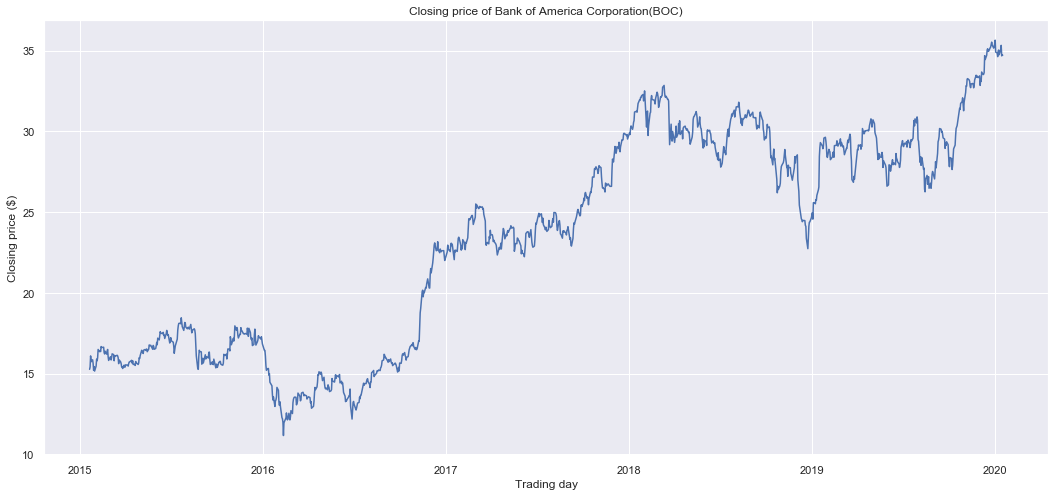

In [3]:
plt.figure(figsize=(18, 8))
plt.plot(data.Close)
plt.title('Closing price of Bank of America Corporation(BOC)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(True)
plt.show()

Moving average

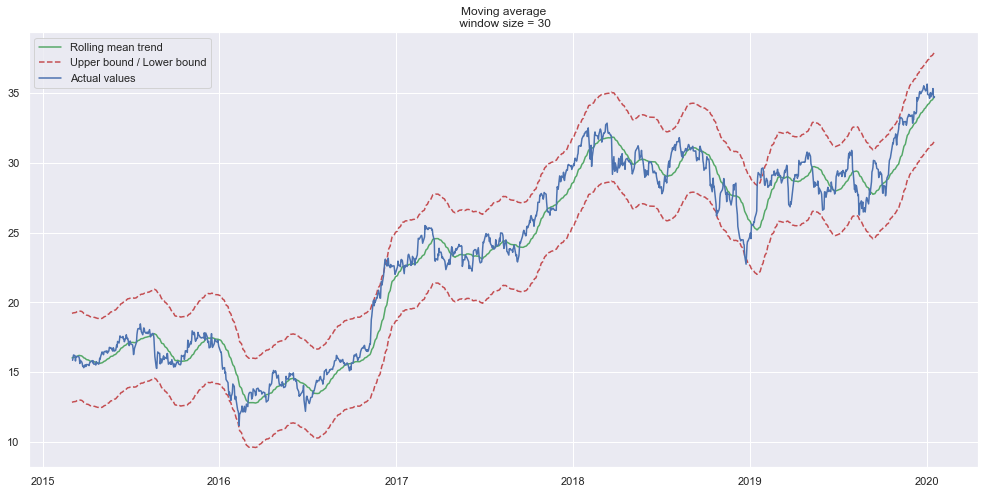

In [4]:
from sklearn.metrics import mean_absolute_error

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)


#Smooth by previous quarter (30 days)
plot_moving_average(data.Close, 30, plot_intervals=True)

Base on the graph, this trend of stock show a upward curve at the end. This might means that the stock is likely to go up in the following days.

### Exponential smoothing
**Simple exponential smoothing**
Do exponential smoothing and use 0.08 and 0.5 as values for the smoothing factor.

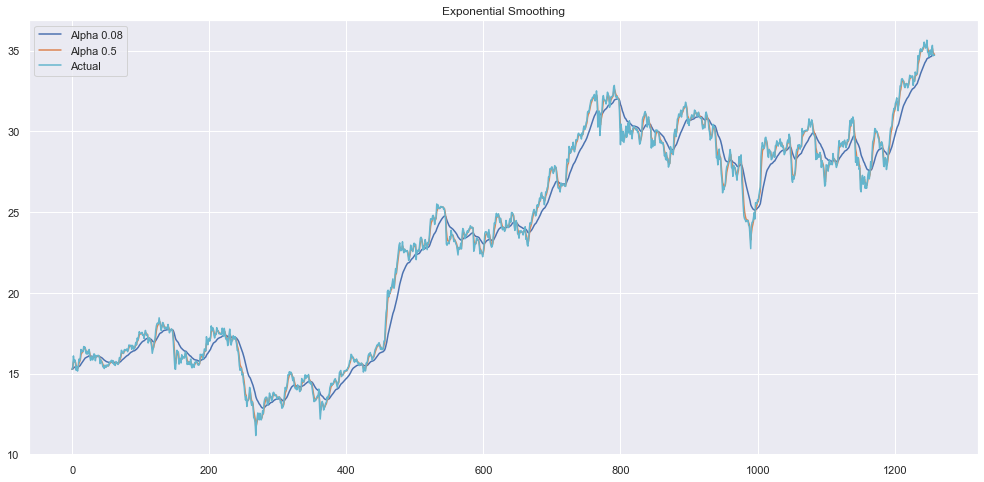

In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(data.Close, [0.08, 0.5])

**Double exponential smoothing**

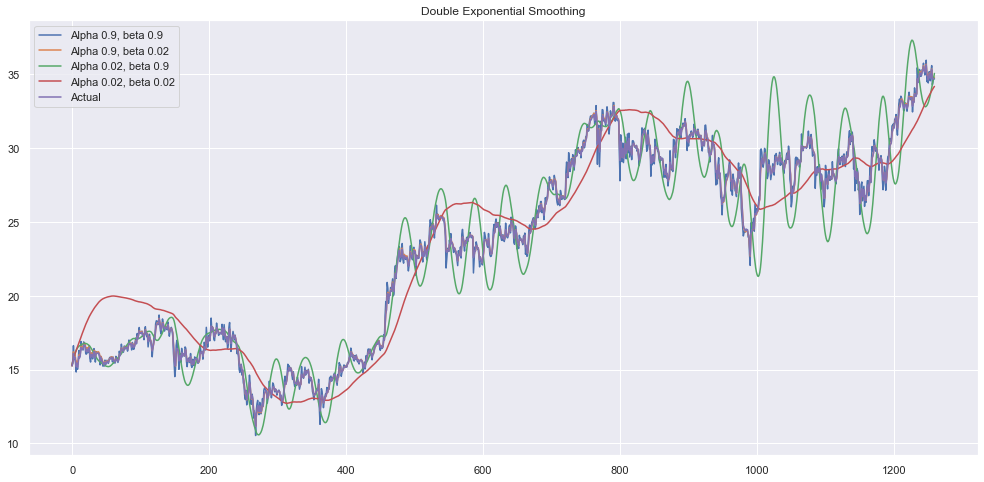

In [6]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

Base on the graph, this Double exponential smoothing trend of stock shows a little bit upward curve at the end. This might means that the stock is likely to go up in the following days.

### Modelling

Turn our series into a **stationary process** in order to model it. we appling the Dickey-Fuller test to see if it is a stationary process. <br>

The Dickey-Fuller test is a point estimate, when it is tiny (say less than 0.01), we can safely say that the time series is stationary. Otherwise, *not*.

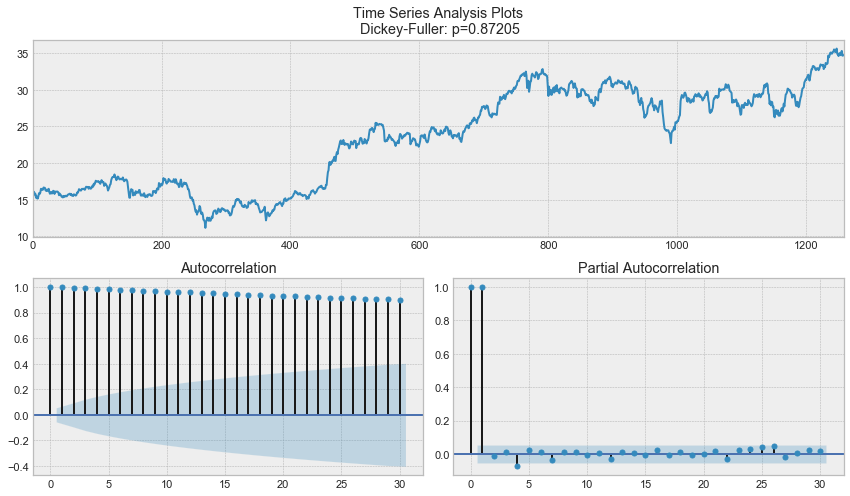

In [22]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)

Conclusion: By the Dickey-Fuller test, the time series is stationary because the Dickey-Fuller point is 0.00270, it's less than 0.01.

### Using random forest from Scikit-learn to predict stock prices

In [23]:
data = pd.read_csv('data/Bank_of_America_Corporation_Historical_Data.csv', parse_dates=[0])
data.head()

,Date,Close,Volume,Open,High,Low
0,2015-01-20,15.26,122920700.0,15.59,15.63,15.20
1,2015-01-21,15.41,100483100.0,15.28,15.57,15.15
2,2015-01-22,16.09,181759900.0,15.55,16.19,15.43
3,2015-01-23,15.73,102799200.0,16.04,16.19,15.73
4,2015-01-26,15.85,69907280.0,15.72,15.93,15.70


In [24]:
### Data transformations
data.columns = [x.strip() for x in data.columns]## strip() using for remove white space on the both side of string.
data.columns = [x.replace(' ', '_') for x in data.columns] ## remove white space
data.head()

,Date,Close,Volume,Open,High,Low
0,2015-01-20,15.26,122920700.0,15.59,15.63,15.20
1,2015-01-21,15.41,100483100.0,15.28,15.57,15.15
2,2015-01-22,16.09,181759900.0,15.55,16.19,15.43
3,2015-01-23,15.73,102799200.0,16.04,16.19,15.73
4,2015-01-26,15.85,69907280.0,15.72,15.93,15.70


Let's see if we can predict Close (y) from the other columns (X).

Any column we want to predict is a y (dependent variable). 
The coluumns that help us predict it are x's (independent variables). 
And we useing a capital X to denote that there are many such columns.

We will train a Random Forest with a sample of our data, then test it with another sample to see how it performs

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [26]:
### sorting data from previous to present
SortedData = data.sort_values(by = 'Date')
SortedData.head(30)
### export_csv = SortedData.to_csv (r'export_dataframe.csv', index = None, header=True) 

,Date,Close,Volume,Open,High,Low
0,2015-01-20,15.26,122920700.0,15.59,15.63,15.20
1,2015-01-21,15.41,100483100.0,15.28,15.57,15.15
2,2015-01-22,16.09,181759900.0,15.55,16.19,15.43
3,2015-01-23,15.73,102799200.0,16.04,16.19,15.73
4,2015-01-26,15.85,69907280.0,15.72,15.93,15.70
5,2015-01-27,15.63,86064430.0,15.55,15.79,15.48
6,2015-01-28,15.20,104900200.0,15.72,15.73,15.18
7,2015-01-29,15.43,75742240.0,15.31,15.49,15.20
8,2015-01-30,15.15,99482560.0,15.23,15.47,15.15
9,2015-02-02,15.46,101291000.0,15.27,15.49,15.12


In [27]:
 # Shift close price up to predict next day
pd.concat([SortedData.Close, SortedData.Close.shift(-1)], axis=1)

,Close,Close
0,15.26,15.41
1,15.41,16.09
2,16.09,15.73
3,15.73,15.85
4,15.85,15.63
...,...,...
1254,35.06,35.32
1255,35.32,34.67
1256,34.67,34.72
1257,34.72,34.71


In [28]:
# Need to remove NA
# Regression - Try to predict Close price (y) from non Close price columns (X)
# Get training set (X_train)
def valid(col):
    return 'Close' not in col and 'Date' not in col
SortedData = SortedData.dropna() ### Pandas dropna() – Drop Null/NA Values from DataFrame 
### Remove the last close price (last row) because there is no tomorrow for the last row to predict!
X = SortedData[[x for x in SortedData.columns if valid(x)]].iloc[:-1] 
y = SortedData.Close.shift(-1).dropna()
### X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

In [29]:
type(X_train)

pandas.core.frame.DataFrame

In [30]:
X_train.sort_index(ascending=True)

,Volume,Open,High,Low
0,122920700.0,15.59,15.63,15.20
3,102799200.0,16.04,16.19,15.73
4,69907280.0,15.72,15.93,15.70
7,75742240.0,15.31,15.49,15.20
11,83481580.0,15.79,16.00,15.75
...,...,...,...,...
1246,29635700.0,35.03,35.26,34.97
1247,37643860.0,35.35,35.66,35.29
1252,39882760.0,35.30,35.33,34.94
1253,39740670.0,35.00,35.07,34.66


In [31]:
type(y_test)

pandas.core.series.Series

In [32]:
y_test.sort_index(ascending=True)

1       16.09
2       15.73
5       15.20
6       15.43
8       15.46
        ...  
1250    34.97
1251    35.03
1254    35.32
1255    34.67
1257    34.71
Name: Close, Length: 629, dtype: float64

In [33]:
# Create a model 
rf_model = RandomForestRegressor()

In [34]:
# Train the model, We learn the trend on the first half of the dataset
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [35]:
# Get R2 measure (indicator of accuracy 1 is perfect 0 is horrible)
rf_model.score(X_test, y_test)

0.9952467611900816

Close to 99%! base on this indicator, the predict must very close to the true data! <br>
Let's plot predictions over actual values to see better:

In [36]:
### Now predict the value of the stock on the second half:
y_pred = rf_model.predict(X_test)

In [37]:
type(y_pred)

numpy.ndarray

In [38]:
y_pred[0:10]

array([15.5793, 22.7082, 15.4386, 24.451 , 15.7511, 16.7137, 14.7738,
       22.9446, 13.2902, 23.9289])

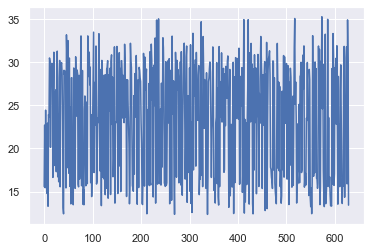

In [39]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

In [40]:
type(y_test)

pandas.core.series.Series

In [41]:
y_test2 = y_test.as_matrix()
type(y_test2)

numpy.ndarray

In [42]:
y_test2[0:10]

array([15.2 , 22.68, 15.46, 24.47, 16.19, 16.63, 14.96, 22.64, 13.27,
       23.65])

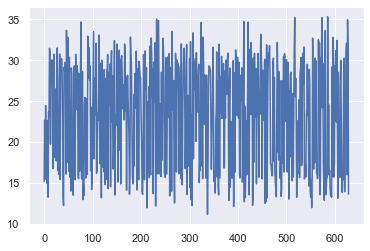

In [43]:
import matplotlib.pyplot as plt
plt.plot(y_test2)

Now let's plot predictions on top of test labels to see if we have a match. We'll plot one under the other and then reverse them to see if the mismatch is big or not:

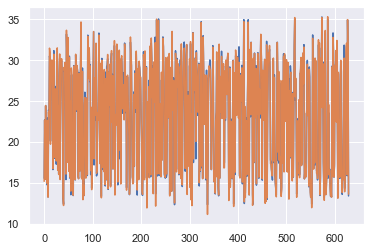

In [44]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)

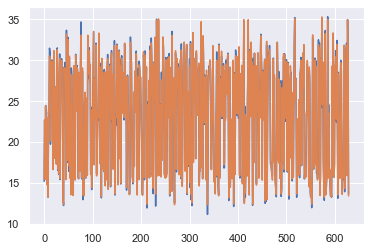

In [45]:
import matplotlib.pyplot as plt
plt.plot(y_test2)
plt.plot(y_pred)

 Let's tabulate:

In [46]:
type(y_test)

pandas.core.series.Series

In [47]:
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

,0,Close
0,15.5793,15.20
1,22.7082,22.68
2,15.4386,15.46
3,24.4510,24.47
4,15.7511,16.19
...,...,...
624,31.8195,32.09
625,15.8960,16.00
626,34.9284,34.97
627,30.0062,31.12


In [48]:
sorted(zip(X.columns, rf_model.feature_importances_),
        key=lambda x: x[1], reverse=True)

[('High', 0.39136194355281084),
 ('Low', 0.37633265866645826),
 ('Open', 0.231521293976375),
 ('Volume', 0.0007841038043559515)]

The highest price of this stock in the day has relatively higher relationship with today's highest price.

In [49]:
myPred = rf_model.predict([[38879690,34.37,34.45,34.23]])

In [50]:
myPred

array([34.7246])

<b>Conclusion :</b> In this model, I entered the stock data on January 21 to predict the close price of the day. The final result was 34.7246, and the actual result was 34.36. Quite similar. The R2 measure of thie model is 0.99.